# **CML1 Project 1: Linear Models**
*Student: Mathias Schindler*

*Date of Submission: Nov 7, 2021*

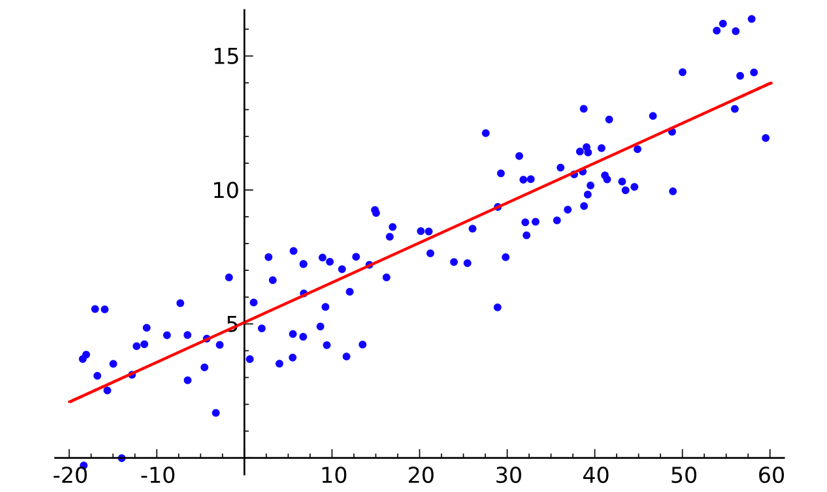

# 0. *Preamble*

In [259]:
#Preamble
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import statsmodels.api as sm
import sklearn

from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/CML1_Projects/Project1_LinearModels/Data')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. **Data Inspection & Preparation**

## 1.1 Loading data

In [260]:
#Load data
# Specify 'index_col' so "lotid" is not treated as predictor in fitted models
train_raw = pd.read_csv("Regression_Supervised_Train.csv", index_col = "lotid")
test_raw = pd.read_csv("Regression_Supervised_Test_updated.csv", index_col = "lotid")
print(train_raw.head(10))
print(test_raw.head(10))

          logerror transactiondate  ...  taxdelinquencyyear  mypointer
lotid                               ...                               
17214744       NaN             NaN  ...                 NaN      25711
12018724       NaN             NaN  ...                 NaN      13268
11306699       NaN             NaN  ...                11.0       5423
11047729       NaN             NaN  ...                 NaN      26198
17174848       NaN             NaN  ...                 NaN      25187
14305657       NaN             NaN  ...                 NaN       6066
11016338       NaN             NaN  ...                 NaN       4138
13961339       NaN             NaN  ...                 NaN       4706
11671803       NaN             NaN  ...                 NaN       5706
11150386       NaN             NaN  ...                 NaN      13350

[10 rows x 47 columns]
          logerror transactiondate  ...  taxdelinquencyflag  taxdelinquencyyear
lotid                               ...     

## 1.2 Introductory Data Preparation

First, the features $totaltaxvalue$, $buildvalue$ or $landvalue$ are removed from the training and test dataset, and also $mypointer$ from the training set as specified in the instructions. \\
Then the data structure, in regards of missing values, is inspected.

In [261]:
def make_nan_fig(df, title):
  nan_df = df.isnull().sum()/len(df)*100
  nan_df = nan_df.sort_values(ascending = False)

  nan_df_fig = plt.bar(nan_df.index, nan_df.values)
  plt.xticks(rotation='vertical', fontsize = 12)
  plt.ylabel('% NaN', fontsize = 12)
  plt.hlines(y=40, xmin= 0, xmax = 40, linestyle = 'dashed')
  plt.title('NaN data in ' + title + ' dataset as proportion of total observations')
  fig = plt.gcf()
  fig.set_size_inches(18, 5)
  plt.show()
  return nan_df_fig


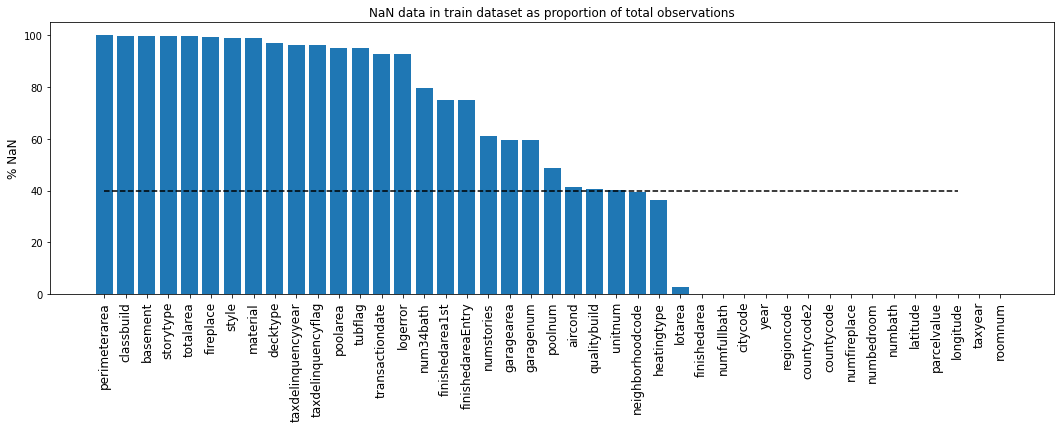

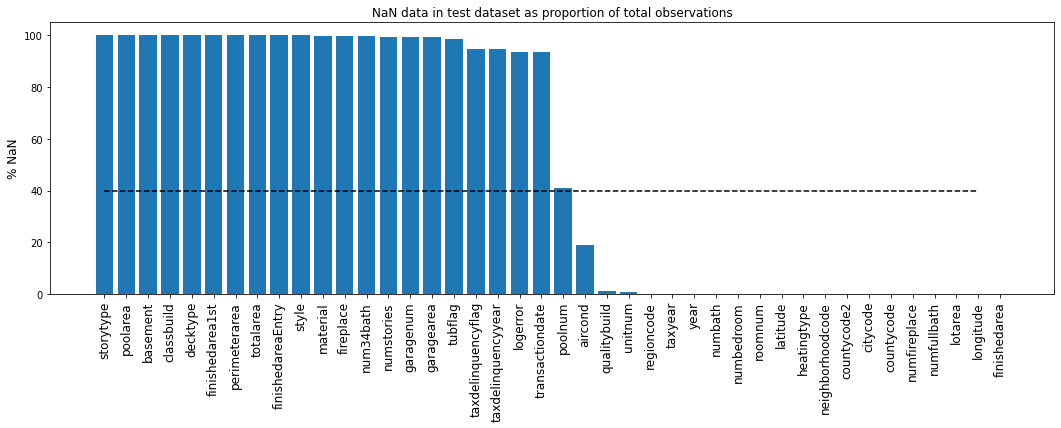

<BarContainer object of 42 artists>

In [262]:
del_feats = ["totaltaxvalue", "buildvalue", "landvalue", "mypointer"]
train_clean = train_raw.drop(del_feats, axis = 1)
test_clean = test_raw.drop(del_feats[0:3], axis = 1)

# Inspect missing data
make_nan_fig(train_clean, "train")
make_nan_fig(test_clean, "test")

So, there is a substantial amount of missing data in both the training and testing dataset. In the training data set we see, that there are 3 variables just over the threshold of 40%. 

## 1.3 Imputing Missing Values for Some Features

All features in the training data for which missing values are imputed have to be transformed in the same way in the testing data. This naturally limits the possibility frontier. \\
From the above bar plot showing percentages of missing data, in the testing data it is seen that $poolnum$ has around 40 pct. missing values while the comparably feature with next-lowst percantage of missing values is $transactiondate$ with around 90 pct. For features with 90 pct. missing values, I do not consider it sensible to impute values as it would be ambiguous as to which method of imputation would be appropriate for these given features.

In [263]:
# Finding the features to impute
na_test = test_clean.isnull().sum()/len(test_clean)*100
na_test = na_test.sort_values(ascending = False)

fillna_feat = na_test[na_test.between(0.001, 60)].index
fillna_feat

Index(['poolnum', 'aircond', 'qualitybuild', 'unitnum'], dtype='object')

So the features that will have imputed values in the datasets are $[poolnum, aircond, qualitybuild, unitnum]$. Here $aircond$ is a categorical variable while the other three are numerical variables. For numerical variables, i.e. $poolnum, qualitybuild, unitnum$, it is most appropriate to impute using the mean of the variables while for the categorical $aircond$ it makes most sense to use the most frequent value (because a non-integer value for a categorical variable would be undefined).

In [264]:
from sklearn.impute import SimpleImputer

#Instantiate SimpleImputer
imp_mn = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mf = SimpleImputer(missing_values=np.nan, strategy='most_frequent')


## FOR THE TRAIN DATA  
train_imp_mn = train_clean[['poolnum', 'qualitybuild', 'unitnum']]
train_imp_mf = train_clean[['aircond']]

#Fit and transform
train_imp_mn = imp_mn.fit_transform(train_imp_mn)
train_imp_mn = pd.DataFrame(train_imp_mn, columns = ['poolnum', 'qualitybuild', 'unitnum'], index = train_clean.index)

train_imp_mf = imp_mf.fit_transform(train_imp_mf)
train_imp_mf = pd.DataFrame(train_imp_mf, columns = ['aircond'], index = train_clean.index)

train_imp = pd.concat([train_imp_mn, train_imp_mf], axis=1) 


## FOR THE TEST DATA  
test_imp_mn = test_clean[['poolnum', 'qualitybuild', 'unitnum']]
test_imp_mf = test_clean[['aircond']]

#Fit and transform
test_imp_mn = imp_mn.fit_transform(test_imp_mn)
test_imp_mn = pd.DataFrame(test_imp_mn, columns = ['poolnum', 'qualitybuild', 'unitnum'], index = test_clean.index)

test_imp_mf = imp_mf.fit_transform(test_imp_mf)
test_imp_mf = pd.DataFrame(test_imp_mf, columns = ['aircond'], index = test_clean.index)

test_imp = pd.concat([test_imp_mn, test_imp_mf], axis=1) 

In [265]:
print(train_clean[['poolnum', 'qualitybuild', 'unitnum', 'aircond']].value_counts())
print(train_imp.value_counts())

print(test_clean[['poolnum', 'qualitybuild', 'unitnum', 'aircond']].value_counts())
print(test_imp.value_counts())

poolnum  qualitybuild  unitnum  aircond
1.0      4.0           1.0      1.0        2845
         7.0           1.0      1.0        1460
         8.0           1.0      1.0        1320
         6.0           1.0      1.0         473
         1.0           1.0      1.0         367
         10.0          1.0      1.0         364
         9.0           1.0      1.0         278
         11.0          1.0      1.0         157
         12.0          1.0      1.0          78
         4.0           2.0      1.0           3
         6.0           2.0      1.0           2
         7.0           2.0      1.0           1
         6.0           4.0      1.0           1
dtype: int64
poolnum  qualitybuild  unitnum  aircond
1.0      5.640235      1.0063   1.0        8483
         4.000000      1.0000   1.0        6470
         7.000000      1.0000   1.0        3813
         8.000000      1.0000   1.0        1662
         5.640235      1.0063   13.0       1203
         1.000000      1.0000   1.0        

In [266]:
# Add features with imputed values 

#To training data
train_clean = train_clean.drop(['poolnum', 'qualitybuild', 'unitnum', 'aircond'], axis = 1)
train_clean = pd.concat([train_clean, train_imp], axis = 1)

#To testing data
test_clean = test_clean.drop(['poolnum', 'qualitybuild', 'unitnum', 'aircond'], axis = 1)
test_clean = pd.concat([test_clean, test_imp], axis = 1)

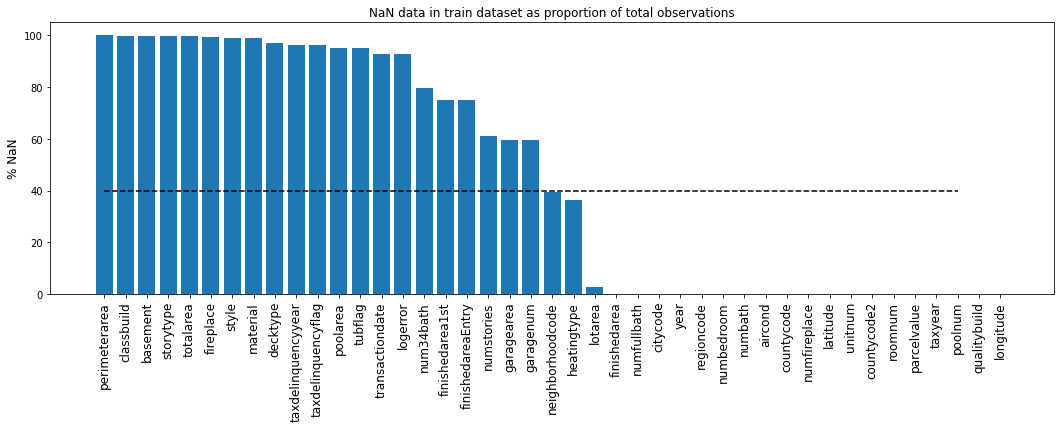

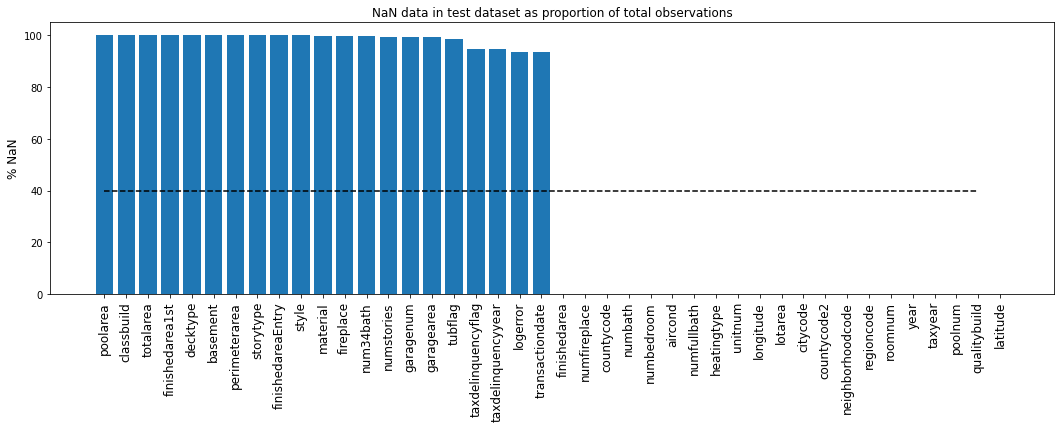

<BarContainer object of 42 artists>

In [267]:
#Reproduce previous figures for missing data
make_nan_fig(train_clean, "train")
make_nan_fig(test_clean, "test")

In [268]:
# Columns in test w. <50% NaN
na_test = test_clean.isnull().sum()/len(test_clean)*100
na_test = na_test.sort_values(ascending = False)
na_test_u50 = na_test[na_test<50]
test_u50_col = na_test_u50.index

# Columns in training dataset
train_col = train_clean.columns

# Difference
test_u50_col.difference(train_col) #None

Index([], dtype='object')

## 1.4 Cleaning Data

In [269]:
# Remove features w. >40% NaN
mypct = 0.6
train_clean = train_clean.dropna(axis = 1, thresh = round(mypct*len(train_clean.index)))
test_clean = test_clean.dropna(axis = 1, thresh = round(mypct*len(test_clean.index)))

# Remove rows w. any NaN
train_clean = train_clean.dropna(axis = 0)

print(train_clean.shape)
print(test_clean.shape)

(12560, 22)
(2746, 21)


In [270]:
# Check difference in columns
def col_diff(df1, df2):
  df1_col = df1.columns
  df2_col = df2.columns

  print("Columns in " + df1.name + " that are not in " + df2.name + ":")
  print(df1_col.difference(df2_col))
  print("\n")
  print("Columns in " + df2.name + " that are not in " + df1.name + ":")
  print(df2_col.difference(df1_col)) 

train_clean.name, test_clean.name = "train", "test"
col_diff(train_clean, test_clean) #No difference


Columns in train that are not in test:
Index(['parcelvalue'], dtype='object')


Columns in test that are not in train:
Index([], dtype='object')


## 1.5 Outlier Detection

There seem to be outliers in $numbath$, $numbedroom$, $finishedarea$, $numfullbath$, $lotarea$, $roomnum$, $unitnum$ and $aircond$. I would have liked to deal with them, however, time did not permit this. The prediction plots in Sections 2.2 and 3.4 indicate that this could be appropriate and might improve prediction accuracy.

In [271]:
train_clean.describe(percentiles=[.01, .1, .25, .5, .75, .90, .95, .99])

,numbath,numbedroom,finishedarea,countycode,numfireplace,numfullbath,heatingtype,latitude,longitude,lotarea,citycode,countycode2,neighborhoodcode,regioncode,roomnum,year,parcelvalue,taxyear,poolnum,qualitybuild,unitnum,aircond
count,12560.000000,12560.000000,12560.000000,12560.000000,12560.000000,12560.00000,12560.000000,1.256000e+04,1.256000e+04,1.256000e+04,12560.000000,12560.000000,12560.000000,12560.000000,12560.000000,12560.000000,1.256000e+04,12560.000000,12560.0,12560.000000,12560.000000,12560.00000
mean,2.632643,3.105414,2014.372373,6037.201433,0.005732,2.63121,2.376115,3.415535e+07,-1.184157e+08,5.791706e+04,23939.173965,3084.381768,152741.581688,96297.695780,0.057882,1969.791401,5.610840e+05,2015.292994,1.0,5.728055,1.001497,1.01879
std,1.108639,1.138279,1211.980196,2.095544,0.082552,1.10942,1.374562,1.515589e+05,1.753259e+05,1.376222e+05,26443.843302,172.882347,172084.738129,155.670755,0.617248,20.184122,8.136490e+05,0.455154,0.0,2.216768,0.089222,0.35554
min,1.000000,0.000000,188.000000,6037.000000,0.000000,1.00000,2.000000,3.360703e+07,-1.188430e+08,8.130000e+02,9840.000000,1286.000000,6952.000000,95982.000000,0.000000,1885.000000,1.647400e+04,2015.000000,1.0,1.000000,1.000000,1.00000
1%,1.000000,1.000000,628.000000,6037.000000,0.000000,1.00000,2.000000,3.375797e+07,-1.187374e+08,2.708360e+03,9840.000000,3101.000000,6952.000000,95989.000000,0.000000,1920.000000,6.216303e+04,2015.000000,1.0,1.000000,1.000000,1.00000
10%,2.000000,2.000000,980.000000,6037.000000,0.000000,2.00000,2.000000,3.397314e+07,-1.186000e+08,5.831900e+03,12447.000000,3101.000000,27080.000000,96027.000000,0.000000,1945.000000,1.385371e+05,2015.000000,1.0,4.000000,1.000000,1.00000
25%,2.000000,2.000000,1275.000000,6037.000000,0.000000,2.00000,2.000000,3.409767e+07,-1.185400e+08,7.372000e+03,12447.000000,3101.000000,34213.000000,96238.000000,0.000000,1956.000000,2.338605e+05,2015.000000,1.0,4.000000,1.000000,1.00000
50%,2.500000,3.000000,1712.500000,6037.000000,0.000000,2.00000,2.000000,3.416664e+07,-1.184498e+08,1.215050e+04,12447.000000,3101.000000,48570.000000,96349.000000,0.000000,1972.000000,3.773915e+05,2015.000000,1.0,6.000000,1.000000,1.00000
75%,3.000000,4.000000,2434.000000,6037.000000,0.000000,3.00000,2.000000,3.423259e+07,-1.183290e+08,4.037500e+04,45457.000000,3101.000000,273263.000000,96379.000000,0.000000,1984.000000,6.145940e+05,2016.000000,1.0,7.000000,1.000000,1.00000
90%,4.000000,5.000000,3299.100000,6037.000000,0.000000,4.00000,2.000000,3.432337e+07,-1.181731e+08,1.582050e+05,54311.000000,3101.000000,276256.000000,96424.000000,0.000000,1995.000000,1.045288e+06,2016.000000,1.0,8.000000,1.000000,1.00000


In [272]:
test_clean.describe(percentiles=[.01, .1, .25, .5, .75, .90, .95, .99])

,numbath,numbedroom,finishedarea,countycode,numfireplace,numfullbath,heatingtype,latitude,longitude,lotarea,citycode,countycode2,neighborhoodcode,regioncode,roomnum,year,taxyear,poolnum,qualitybuild,unitnum,aircond
count,2746.000000,2746.000000,2746.000000,2746.000000,2746.000000,2746.000000,2746.000000,2.746000e+03,2.746000e+03,2.746000e+03,2746.000000,2746.000000,2746.000000,2746.000000,2746.000000,2746.000000,2746.000000,2746.0,2746.000000,2746.0,2746.000000
mean,2.631282,3.143481,2024.040422,6037.144210,0.003277,2.630007,2.398398,3.415338e+07,-1.184131e+08,5.326194e+04,23873.924982,3089.102695,153406.352149,96292.648216,0.039694,1968.237436,2015.280408,1.0,5.703840,1.0,1.019665
std,1.077071,1.101988,1103.844433,1.775659,0.057166,1.078028,1.409589,1.535070e+05,1.744567e+05,1.351998e+05,24224.423884,146.491904,167982.420909,152.440454,0.491336,20.611783,0.449280,0.0,2.160287,0.0,0.316480
min,1.000000,0.000000,450.000000,6037.000000,0.000000,1.000000,2.000000,3.365816e+07,-1.188493e+08,1.036000e+03,9840.000000,1286.000000,6952.000000,95982.000000,0.000000,1894.000000,2015.000000,1.0,1.000000,1.0,1.000000
1%,1.000000,1.000000,653.900000,6037.000000,0.000000,1.000000,2.000000,3.376139e+07,-1.187429e+08,3.060750e+03,12447.000000,3101.000000,6952.000000,95986.000000,0.000000,1920.000000,2015.000000,1.0,1.000000,1.0,1.000000
10%,1.000000,2.000000,973.000000,6037.000000,0.000000,1.000000,2.000000,3.395867e+07,-1.185966e+08,5.700500e+03,12447.000000,3101.000000,27080.000000,96027.000000,0.000000,1941.000000,2015.000000,1.0,4.000000,1.0,1.000000
25%,2.000000,2.000000,1275.000000,6037.000000,0.000000,2.000000,2.000000,3.409442e+07,-1.185397e+08,7.175500e+03,12447.000000,3101.000000,37739.000000,96237.000000,0.000000,1954.000000,2015.000000,1.0,4.000000,1.0,1.000000
50%,3.000000,3.000000,1754.500000,6037.000000,0.000000,3.000000,2.000000,3.416729e+07,-1.184480e+08,1.145000e+04,12447.000000,3101.000000,51906.000000,96349.000000,0.000000,1970.000000,2015.000000,1.0,6.000000,1.0,1.000000
75%,3.000000,4.000000,2426.750000,6037.000000,0.000000,3.000000,2.000000,3.423401e+07,-1.183174e+08,3.401200e+04,45457.000000,3101.000000,273400.000000,96378.750000,0.000000,1983.000000,2016.000000,1.0,7.000000,1.0,1.000000
90%,4.000000,4.000000,3389.000000,6037.000000,0.000000,4.000000,2.000000,3.432085e+07,-1.181699e+08,1.422465e+05,54311.000000,3101.000000,276256.000000,96424.000000,0.000000,1993.000000,2016.000000,1.0,8.000000,1.0,1.000000


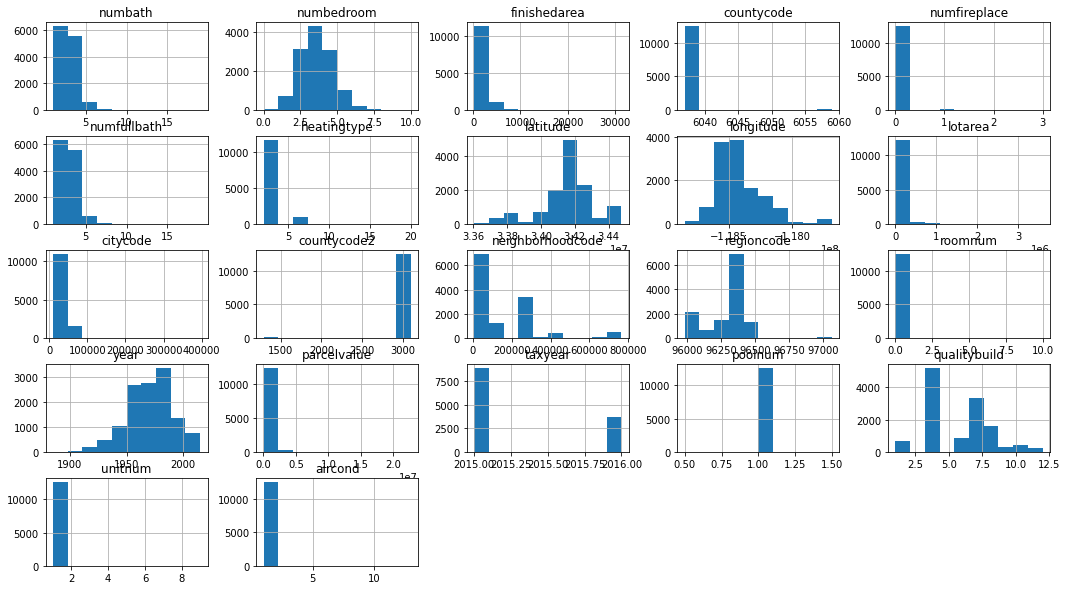

In [273]:
def features_hist(df):
  df.hist()
  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.show()

features_hist(train_clean)

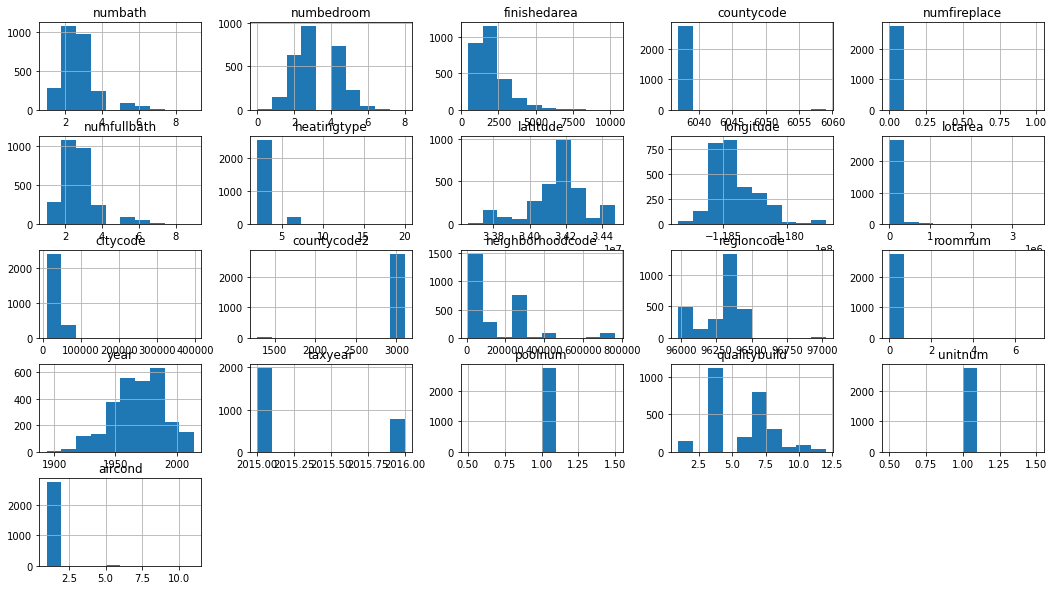

In [274]:
features_hist(test_clean)

## 1.6 Getting Dummies for Categorical Features

From the $Case\_data\_dictionary.xlsx$-file the following features do not have a natural ordering and are hence considered categorical:


*   $aircond$
*   $style$
*   $classbuild$
*   $countycode$
*   $fireplace$
*   $tubflag$
*   $heatingtype$
*   $countycode2$
*   $citycode$
*   $regioncode$
*   $neighborhoodcode$
*   $storytype$
*   $material$




In [275]:
cat_feat = ['aircond', 'style', 'classbuild', 'countycode', 'fireplace', 'tubflag', 'heatingtype', 'countycode2', 'citycode', 'regioncode', 'neighborhoodcode', 'storytype', 'material']

def is_in_df(vars, df, df_style):
  vars_in_df = []
  for i in vars:
    if i in df.columns:
        print("Yes, " + str(i) + " is in " + df_style)
        vars_in_df.append(i)
    else:
        print("No, " + str(i) + " is not in " + df_style)
  print(vars_in_df)
  return vars_in_df

# I run the function on train and test so make sure they are the same
print("Train:")
cat_feat_train = is_in_df(cat_feat, train_clean, "train")
print("\n Test:")
cat_feat_test = is_in_df(cat_feat, test_clean, "test")

Train:
Yes, aircond is in train
No, style is not in train
No, classbuild is not in train
Yes, countycode is in train
No, fireplace is not in train
No, tubflag is not in train
Yes, heatingtype is in train
Yes, countycode2 is in train
Yes, citycode is in train
Yes, regioncode is in train
Yes, neighborhoodcode is in train
No, storytype is not in train
No, material is not in train
['aircond', 'countycode', 'heatingtype', 'countycode2', 'citycode', 'regioncode', 'neighborhoodcode']

 Test:
Yes, aircond is in test
No, style is not in test
No, classbuild is not in test
Yes, countycode is in test
No, fireplace is not in test
No, tubflag is not in test
Yes, heatingtype is in test
Yes, countycode2 is in test
Yes, citycode is in test
Yes, regioncode is in test
Yes, neighborhoodcode is in test
No, storytype is not in test
No, material is not in test
['aircond', 'countycode', 'heatingtype', 'countycode2', 'citycode', 'regioncode', 'neighborhoodcode']


In [276]:
# Inspect the unique values of each categorical feature
for q in ["train_clean", "test_clean"]:
  print(str(q) + "\n" + "-----------------------------------------------------------------------------------")
  if q == "train_clean":
    for i in cat_feat_train:
      print(str(i) + "\n")
      print(train_clean[i].value_counts())
  else:
    for i in cat_feat_test:
      print(str(i) + "\n")
      print(test_clean[i].value_counts())  
  print("\n\n")

# Features "aircond", "countycode", "countycode2", and "heatingtype" have very little variation
# "Citycode", "regioncode" and "neighborhoodcode" have variation

train_clean
-----------------------------------------------------------------------------------
aircond

1.0     12516
5.0        35
11.0        6
13.0        3
Name: aircond, dtype: int64
countycode

6037    12445
6059      115
Name: countycode, dtype: int64
heatingtype

2.0     11621
7.0       830
6.0        99
20.0        9
18.0        1
Name: heatingtype, dtype: int64
countycode2

3101    12445
1286      115
Name: countycode2, dtype: int64
citycode

12447.0     8730
54311.0     1219
46298.0      610
45457.0      556
47019.0      457
54722.0      179
9840.0       133
30908.0       92
54299.0       88
39308.0       79
26964.0       71
16764.0       70
51617.0       52
51861.0       48
37688.0       44
396054.0      38
47568.0       22
52650.0       22
48424.0       16
12520.0       11
42150.0       11
33612.0       11
53571.0        1
Name: citycode, dtype: int64
regioncode

96389.0    414
96364.0    335
96379.0    322
96356.0    320
96339.0    298
          ... 
96212.0      1
96217

Now dummies variables for the categorical features are created. Although $regioncode$ and $neighborhoodcode$ are categorical features there are too many instances where the unique codes are different in the training and testing dataset, respectively. Hence, they will not be transformed with dummies.

In [277]:
# Creating dummies for categorical variables:
col_list = ['aircond', 'countycode', 'countycode2', 'heatingtype', 'citycode']
prfx_dict = {'aircond': 'ac_', 'countycode': 'county_', 'countycode2': 'county2_', 'heatingtype': 'heat_', 'citycode': 'city_'}

train_clean = pd.get_dummies(train_clean, prefix=prfx_dict, columns=col_list, drop_first = True)
test_clean = pd.get_dummies(test_clean, prefix=prfx_dict, columns=col_list, drop_first = True)

In [278]:
# Check difference in columns
train_clean.name, test_clean.name = "train", "test"
col_diff(train_clean, test_clean)

#Value counts of the differences in features:
print("\n\n")
for i in [["ac__13.0", "city__53571.0", "heat__18.0"]]:
  print(train_clean[i].value_counts())

Columns in train that are not in test:
Index(['ac__13.0', 'city__53571.0', 'heat__18.0', 'parcelvalue'], dtype='object')


Columns in test that are not in train:
Index([], dtype='object')



ac__13.0  city__53571.0  heat__18.0
0         0              0             12555
1         0              0                 3
0         1              0                 1
          0              1                 1
dtype: int64


Deleting $aircond==13$; $citycode==53571$ and $heatingtype==18$ only reduces the training dataset with at most five observations while making sure that the columns are the same across the training and testing dataset. These few observations should not change the results much. In this case, I therefore determine that the benefits outweight the costs of removing these columns from the training dataset:

In [279]:
for i in ["ac__13.0", "city__53571.0", "heat__18.0"]:
  train_clean = train_clean.drop(i, axis = 1)

In [280]:
#Final check of comparison
train_clean.name, test_clean.name = "train", "test"
col_diff(train_clean, test_clean) #No diff

Columns in train that are not in test:
Index(['parcelvalue'], dtype='object')


Columns in test that are not in train:
Index([], dtype='object')


Now, the data is split into the dependent variable $parcelvalue$ and its predictors:

In [281]:
y = train_clean["parcelvalue"]
x = train_clean.drop("parcelvalue", axis=1)

## 1.7 Polynomial Features

In order to capture non-linear relationsships in features, polynomial transformation of features is employed in this section. The reason for choosing a polynomial degree of 2 instead of 3 is explained in more detail in Section 3.4. \\
The reason for not choosing degree 4 (or higher) is computational infeasibility in Google Colab.

In [282]:
from sklearn.preprocessing import PolynomialFeatures as plf

# Set degree
degree = 2

# Instantiate polynomial transformer
poly = plf(degree, include_bias = False)

*Footnote for Prof. Roger Garriga: I know the code below is not very DRY, but I have been unable to compress it. 



In [283]:
#Consider only non-dummy features
x_poly = x.iloc[:,0:16]
test_poly = test_clean.iloc[:,0:16]

#Get index of original dfs
x_idx = x.index
test_clean_idx = test_clean.index

# Fit and transform features
x_poly = poly.fit_transform(x_poly)
test_poly = poly.fit_transform(test_poly)

# Get feature names (after fit of poly)
x_poly_colnames = x.iloc[:,0:16]
test_poly_colnames = test_clean.iloc[:,0:16]

poly_col_names_x = poly.get_feature_names(x_poly_colnames.columns)
poly_col_names_test = poly.get_feature_names(test_poly_colnames.columns)

# Add feature names
x_poly = pd.DataFrame(x_poly, columns = poly_col_names_x, index = x_idx)
test_poly = pd.DataFrame(test_poly, columns = poly_col_names_test, index = test_clean_idx)

#Put datasets back together
x = pd.concat([x.iloc[:,16:], x_poly], axis = 1)
test_clean = pd.concat([test_clean.iloc[:,16:], test_poly], axis = 1)


If time had permitted, it would have been nice to check for outliers. The prediction plots in Sections 2.2 and 3.4 indicate that this could be appropriate. The baseline OLS is sensitive to outliers, however the LASSO model should be less so, due to the penalty term being the absolute value. \\
Analysis of outliers could have included observing each feature's distribution and then deciding the outlier removal strategy such as only keeping some observations in a inter-quartile range.

# 2. **Baseline OLS Predictions**

## 2.1 Running the OLS

First, baseline OLS regression is run:

In [284]:
from sklearn.linear_model import LinearRegression

# Instantiate model
regr = LinearRegression()

# Fit model
regr.fit(x,y)

# Display parameter estimates
print(np.array(list(map('{:.7f}'.format, regr.coef_))))

['-93603.7263781' '13921.7770388' '-173048.5219971' '20601.3929786'
 '-45682.6660750' '-13513.4916517' '90779.7675551' '230560.6115682'
 '-423936.5876631' '-44838.9795549' '593445.0019103' '-328467.1413090'
 '524645.3721545' '387838.3773794' '-445369.9846479' '222384.7926540'
 '228394.7083273' '358199.2993339' '343277.6449081' '-102984.4781136'
 '96623.5267804' '143186.4934244' '-425066.6236268' '210435.6564687'
 '852709.4939802' '513358.8674864' '361604.0864678' '150875.4732674'
 '114.0800640' '347.9015097' '11696.3249325' '10.9935163' '138.6743426'
 '-145.4322641' '-733.8066841' '-334.4008963' '167.3723575'
 '389120.4700993' '560.4361421' '-2326.8942271' '3.2061756' '-0.0004675'
 '-497.1880490' '6.4330095' '22071.1493653' '-40553.4662412' '145.7105887'
 '-46527.1526676' '11563.7731905' '-0.7764513' '0.1420555' '46.3265792'
 '1.0753442' '1419.6057097' '-39073.0786566' '1192.0944497'
 '-48308.3854253' '121.7060507' '1703.0038110' '-675.6821780'
 '-14867.4006298' '36.9033862' '48072.833

In [233]:
# Produce predictions using test dataset
y_hat_test = regr.predict(test_clean)
y_hat_test

array([498967.53216553, 617832.83299255, 660276.16183472, ...,
       500112.9216156 , 478086.84020996, 389125.83229065])

## 2.2 Assessing the OLS

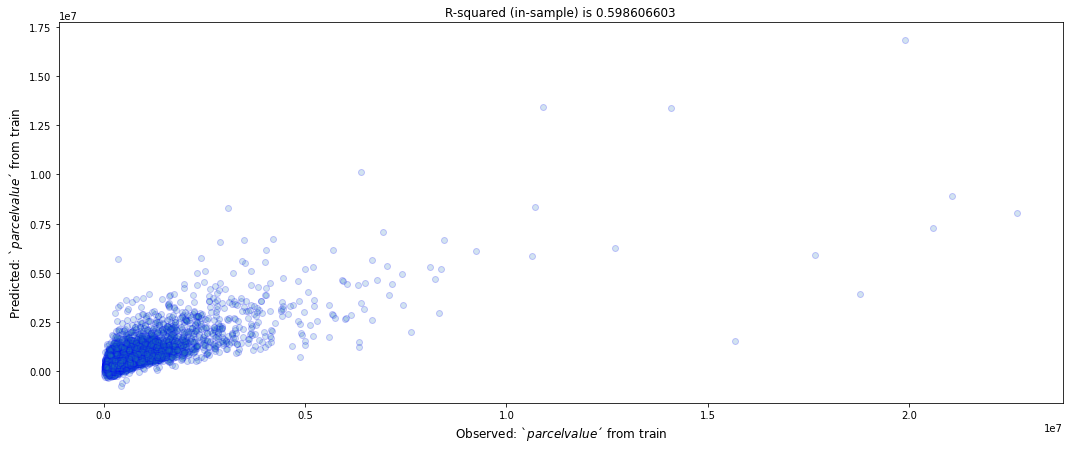

In [240]:
from sklearn.metrics import r2_score

# Visualizing predictions in-sample
y_hat_insample = regr.predict(x)

def accuracy_fig(y_train, y_pred, pred_type):
  plt.figure()
  plt.scatter(x=y_train,y=y_pred, alpha=0.2, edgecolors='b')   
  plt.xlabel('Observed: `$parcelvalue$´ from train', fontsize = 12)
  plt.ylabel('Predicted: `$parcelvalue$´ from train', fontsize = 12)
  plt.title("R-squared (" +  pred_type + ") is " + "{:.9f}".format(r2_score(y_train, y_pred)) )
  pred_fig = plt.gcf()
  pred_fig.set_size_inches(18, 7)
  plt.show()

accuracy_fig(y, y_hat_insample, "in-sample")

Estimating out-of-sample accuracy employing cross-validation. A 100-fold splitting strategy is chosen for computational efficiency (relative to the leave-one-out strategy):

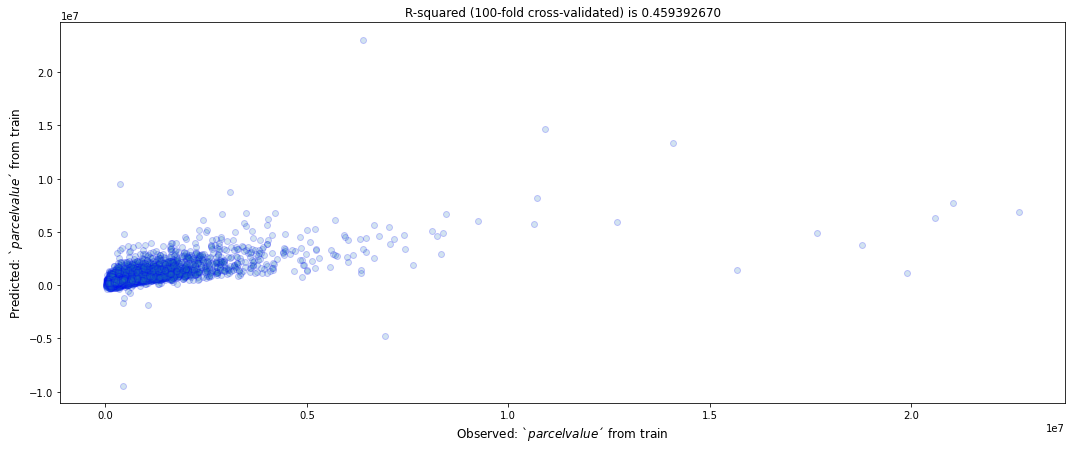

In [241]:
from sklearn.model_selection import cross_val_predict as cvp

y_hat_cv = cvp(regr, x, y, cv=100) #Run time: 22s

accuracy_fig(y, y_hat_cv, "100-fold cross-validated")

# 3. **LASSO**

## 3.1 Preprocessing Data

For LASSO it is essential to standardize predictors so the penalty term works on the same units:

In [242]:
from sklearn import preprocessing

# Instantiate scaler
scaler = preprocessing.StandardScaler()

# Fit to training set
scaler.fit(x)

# Transform training and testing data based on values of training set (no refit to test data, just transforming):
x_scaled = scaler.transform(x)
x_scaled = pd.DataFrame(x_scaled, columns = x.columns, index = x.index)

test_scaled = scaler.transform(test_clean)
test_scaled = pd.DataFrame(test_scaled, columns = test_clean.columns, index = test_clean.index)

## 3.2 Hyperparameter Optimization

For finding the optimal hyperparameter, a hyperparameter searching strategy using the AIC criterion (instead of grid-searching which is computationally intensive), as is mentioned in the summary of the 'LinearModels' notebook, is preferred. An intercept is fitted as the $y$-values are not scaled.

In [243]:
from sklearn.linear_model import LassoLarsIC

model_aic = LassoLarsIC(criterion="aic", fit_intercept=True, normalize=False, max_iter=500)
model_aic.fit(x_scaled, y)

print("Optimal alpha (using AIC criterion) is: \n" + str(model_aic.alpha_))

Optimal alpha (using AIC criterion) is: 
1954.5364113287633


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 54 iterations, i.e. alpha=3.909e+03, with an active set of 40 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 56 iterations, i.e. alpha=3.228e+03, with an active set of 42 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 75 iterations, alpha=1.955e+03, previous alpha=1.955e+03

## 3.3 Running the LASSO

Then the LASSO model is fitted on the scaled data using the hyperparameter found before, and predicitions using the test dataset are made.

In [244]:
%%capture
from sklearn.linear_model import Lasso

# Instantiate Lasso
print(model_aic.alpha_)
regr_lasso = Lasso(alpha = model_aic.alpha_, fit_intercept=True, warm_start=True, max_iter= 1000)

# Fit Lasso
regr_lasso.fit(x_scaled,y)                          

## 3.4 Assessing the LASSO

In [245]:
# Investigating how many features have been 'killed' by LASSO
print(np.count_nonzero(regr_lasso.coef_==0))
x_scaled.shape

122


(12560, 180)

In the code cell below the features which survived LASSO's feature selection are presented. These are the reason that I decide to use a polynomial transformation of degree 2 instead of 3 (or higher). \\
Running the LASSO with polynomials of degree 3 gives a modest increase in the Kaggle-score. However, the selected variables with polynomial degree 2 seem more credible to me (and might hence be an indication of overfitting using polynomials of degree 3). With 3rd degree polynomials the selected features of order 1 are mainly city and county codes and otherwise they are interactions which seem quite arbitrarily chosen. \\
I therefore choose to follow the economist-minded way of thinking and keeping the features that I believe have the most inherent explanatory power rather than only looking at performance metrics. This might be a mistake, which remains to be seen ...

In [246]:
# Investigating which features 'survived' LASSO
survived_feats = list(zip(regr_lasso.coef_, x_scaled))

for i in range(len(survived_feats)):
  if survived_feats[i][0]!= 0:
    print(survived_feats[i][1])

ac__5.0
county__6059
county2__3101
heat__7.0
city__12447.0
city__12520.0
city__16764.0
city__26964.0
city__30908.0
city__33612.0
city__37688.0
city__39308.0
city__42150.0
city__45457.0
city__46298.0
city__47019.0
city__51617.0
city__51861.0
city__54299.0
city__54722.0
city__396054.0
finishedarea
longitude
taxyear
numbath^2
numbath finishedarea
numbath numfullbath
numbath lotarea
numbath unitnum
numbedroom^2
numbedroom latitude
numbedroom lotarea
numbedroom neighborhoodcode
numbedroom qualitybuild
finishedarea^2
finishedarea numfireplace
finishedarea numfullbath
finishedarea longitude
finishedarea lotarea
finishedarea neighborhoodcode
finishedarea year
finishedarea unitnum
numfullbath^2
numfullbath lotarea
numfullbath neighborhoodcode
numfullbath unitnum
latitude regioncode
latitude year
longitude poolnum
lotarea^2
lotarea neighborhoodcode
lotarea qualitybuild
neighborhoodcode qualitybuild
regioncode taxyear
taxyear^2
taxyear poolnum
qualitybuild^2
qualitybuild unitnum


In [247]:
# Produce predictions using test dataset
y_hat_lasso_test = regr_lasso.predict(test_scaled)
y_hat_lasso_test

array([634709.22279879, 651350.9177512 , 245776.05814745, ...,
       609118.2193544 , 307893.93271675, 390066.1107375 ])

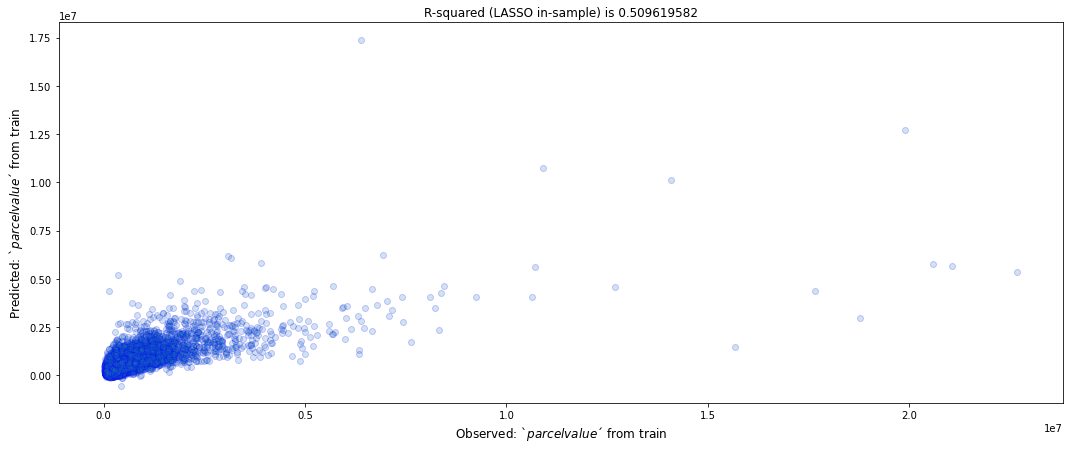

In [248]:
# Visualizing predictions (in-sample)
y_hat_lasso_insample = regr_lasso.predict(x_scaled)

accuracy_fig(y, y_hat_lasso_insample, "LASSO in-sample")

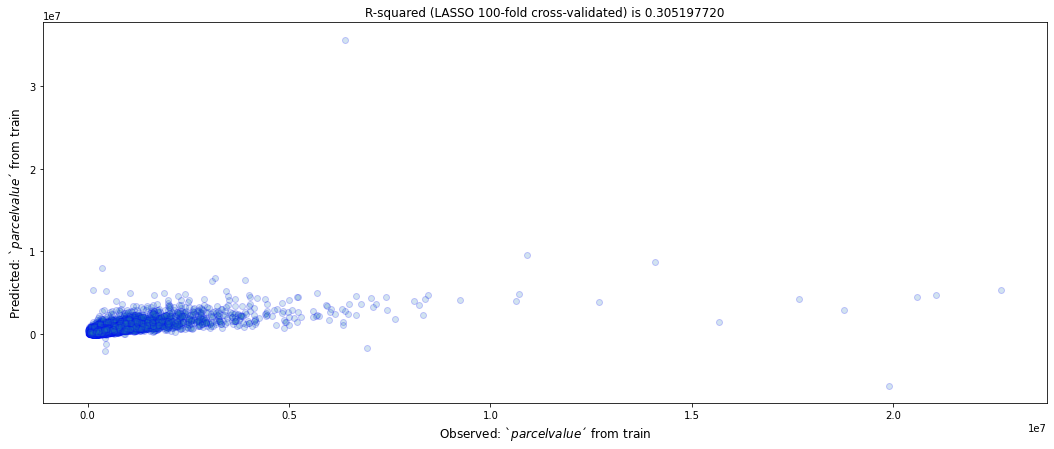

In [250]:
# Visualizing predictions (out-of-sample)
import warnings
warnings.filterwarnings('ignore')

y_hat_cv_lasso = cvp(regr_lasso, x, y, cv=100) #Run time: 4min

accuracy_fig(y, y_hat_cv_lasso, "LASSO 100-fold cross-validated")

warnings.filterwarnings('default')

# 4. **Exporting Predictions for Kaggle-Submission**

Lastly, the predicted values of $parcelvalue$ from the LASSO model, along with its identifier $lotid$, are exported to a .csv-file suitably formatted for Kaggle.

In [110]:
# .csv for Kaggle-submission
submission = pd.DataFrame({"lotid": test_clean.index, "parcelvalue": y_hat_lasso_test})
print(submission.shape)
submission.to_csv("/content/drive/My Drive/CML1_Projects/Project1_LinearModels/Predictions/pred14_2_poly3_lasso-alpha14117.csv", index = False)

(2746, 2)
